In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [2]:
# Search for images from DuckDuckGo and return only the 'image' value
from duckduckgo_search import DDGS, AsyncDDGS
from fastcore.all import *
import time
import json

async def search_images(term, max_images=150):
    image_results = await AsyncDDGS().aimages(term, max_results=max_images)
    # Create empty set
    image_urls = set()
    for r in image_results:
        image_url = r['image']
        image_urls.add(r['image'])
        time.sleep(0.2)
    return L(image_urls)[:max_images]

urls = await search_images('artic hare')
urls

(#150) ['https://i.pinimg.com/originals/c7/82/07/c7820714dfa52093fa9e5a1eaedce3b2.jpg','https://upload.wikimedia.org/wikipedia/commons/e/e3/Arctic_Hare_1.jpg','https://s3.animalia.bio/animals/photos/full/1.25x1/shutterstock-596894762jpg.webp','https://storage.googleapis.com/oceanwide_web/media-dynamic/cache/widen_900/v2-gallery_media/media62fcdb41d9102041539951.jpg','https://pix.avax.news/avaxnews/7a/3f/00013f7a_medium.jpeg','https://i.pinimg.com/originals/5d/9a/19/5d9a19c063d39766eaad8fb2d62d0b41.jpg','http://4.bp.blogspot.com/-xH2BckIRfw0/UNkrXkYEZgI/AAAAAAAABLs/LALUsGVRlf4/s1600/Arctic+Hare+8.jpg','https://4.bp.blogspot.com/-smaVjP0TYUk/V0IPaArDZuI/AAAAAAAAA5Y/OSdKYNozbKYtVJNfuQC46vU_A6xMb6tuACLcB/s1600/arctic+hare-1.jpg','http://1.bp.blogspot.com/-rFHOiVuYlOc/VWvr8TqdgzI/AAAAAAAABOw/x9V4l3XmDi4/s1600/The+Arctic+Hare+-+001.jpeg','https://windows10spotlight.com/wp-content/uploads/2021/07/de32e034980f5f102c99abb7d67667ac.jpg'...]

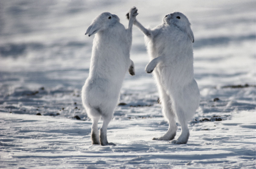

In [3]:
# Try downloading one image from the search

from fastdownload import download_url
dest = 'animal.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [4]:
from time import sleep

artic_animals = ['artic fox', 'polar bear', 'artic hare', 'artic wolf']

path = Path('animals')

if not path.exists():
    path.mkdir()
    
for o in artic_animals:
    file_name = o.replace(" ", "_")
    dest = (path/file_name)
    dest.mkdir(exist_ok=True)
    results = await search_images(o)
    download_images(dest, urls=results)
    sleep(10)

In [5]:
# Verify that the images can be downloaded and remove any that can't be verified

for o in artic_animals:
    file_name = o.replace(" ", "_")
    dest = (path/file_name)
    fns = get_image_files(dest)
    failed = verify_images(fns)
    failed.map(Path.unlink)
    
# fns = get_image_files('animals/artic_hare')
# failed = verify_images(fns)
# failed


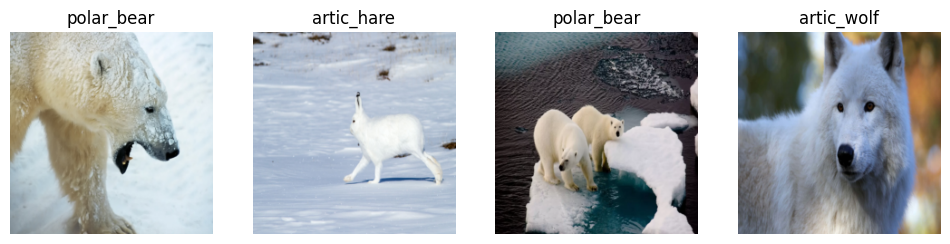

In [6]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
)

animals = animals.new(
    item_tfms=RandomResizedCrop(224,min_scale=0.3),
    batch_tfms=aug_transforms()
)
dls = animals.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.9MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.848636,0.176681,0.051020,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.511702,0.180612,0.051020,01:13
1,0.453111,0.153907,0.040816,01:13
2,0.367171,0.116988,0.040816,01:11
3,0.329602,0.108631,0.051020,01:13


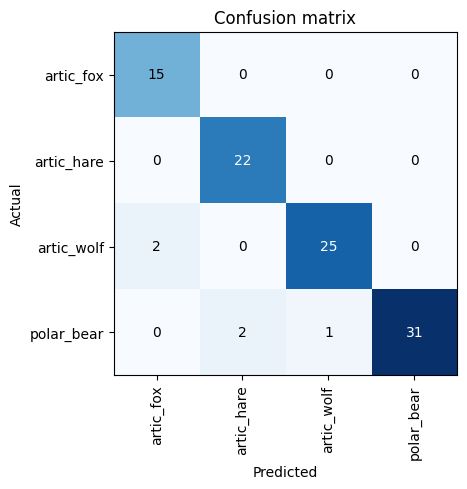

In [8]:
# See where the model is getting confused
# Create a confusion matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()